In [5]:
import seaborn as sns
import pandas as pd

sns.set_theme()

In [6]:
dataset = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

## EDA

In [2]:
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Рассмотрим самые популярные слова: 

In [ ]:
from collections import Counter
from itertools import chain, islice

word_counter = Counter(chain.from_iterable((sentence.split(' ') for sentence in dataset['review'])))

In [13]:
word_counter.most_common(20)

[('the', 568723),
 ('a', 306953),
 ('and', 301892),
 ('of', 283618),
 ('to', 261847),
 ('is', 203047),
 ('in', 169976),
 ('I', 132488),
 ('that', 126811),
 ('this', 113720),
 ('it', 107894),
 ('/><br', 100974),
 ('was', 92656),
 ('as', 83127),
 ('with', 82563),
 ('for', 80914),
 ('The', 67290),
 ('but', 66261),
 ('on', 61192),
 ('movie', 60754)]

Видем, что чаще всего встречаются предлоги, артикли, местоимения. Также встретилось сочетание `/><br`, значит необходимо отчистить текст от HTML тегов.

In [6]:
review_lenghts = dataset['review'].apply(lambda x: len(x.split(' ')))

Найдем среднюю длину отзыва:

In [7]:
review_lenghts.mean()

231.14594

Выведем гистограмму:

<Axes: xlabel='review', ylabel='Count'>

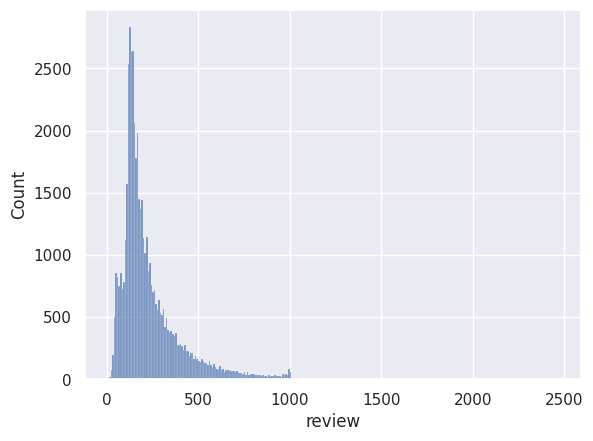

In [8]:
sns.histplot(data=review_lenghts)

По графику видно, что медианная длина также находится около 231 слов. Это означает, что нам должно хватить информации для определения тона отзыва (мало коротких отзывов).

Среднее количество предложений в отзыве:

In [34]:
sentence_counts = dataset['review'].apply(lambda x: len(x.split('.')))
sentence_counts.mean()

14.0104

В среднем отызывы достаточно длинные, что также говорит в пользу предыдущего утверждения.

Среднее количество слов в предложении:

In [49]:
sentence_word_count = []
for _, review in dataset['review'].items():
    for sentence in review.split('.'):
        if sentence:
            sentence_word_count.append(len(sentence.split(' ')))
                                       
mean(sentence_word_count)

19.998218601825315

Рассмотрим баланс классов:

In [1]:
dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Классы сбалансированы.

## Preprocessing

Функция предобработки текста:

1. приведение к нижнему регистру
2. удаление HTML тегов и пунктуации
3. фильтрация стоп-слов

In [7]:
import re
import nltk

nltk.download("wordnet")

def preprocess_text(text, stopwords, lemmatizer):
#     print(type(text))
    lowered_text = text.lower().strip()
    filtered_text = re.sub(r'<[^>]*>|[^a-zA-Z]', ' ', lowered_text) # clean from punctuation and HTML tags
    lemmed_text = ' '.join(lemmatizer.lemmatize(text) for text in filtered_text.split() if text not in stopwords)
    return lemmed_text
    

In [8]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

Применим функцию выше к датасету:

In [9]:
import nltk.corpus
from nltk.stem import WordNetLemmatizer

    
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

dataset['preprocessed_review'] = dataset['review'].apply(lambda text: preprocess_text(text, stopwords, lemmatizer))

Пример обработки текста было/стало

In [1]:
dataset.iloc[0].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [51]:
dataset.iloc[0].iloc[2]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

## Word Vectorizer

Токенизируем тексты:

In [ ]:
from nltk.tokenize import word_tokenize
from itertools import chain

documents = [word_tokenize(text) for text in dataset['preprocessed_review']]
vocabulary = set(chain.from_iterable(documents))
token_to_index = {token: i for i, token in enumerate(vocabulary)}
index_to_token = {i: token for token, i in token_to_index.items()}

### Матрица совстречаемости

Подготовим маппинги для всех контекстов в датасете:

In [26]:
from tqdm.notebook import tqdm

WINDOW_SIZE = 5
contexts = set()
for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        contexts.add(current_context)
context_to_index = {token: i for i, token in enumerate(contexts)}
index_to_context = {i: token for token, i in context_to_index.items()}

  0%|          | 0/50000 [00:00<?, ?it/s]

Подготовим матрицу совстречаемости:

In [29]:
from scipy.sparse import csc_matrix, lil_matrix, dok_array

coocurence_contex_matrix = dok_array((len(vocabulary), len(contexts)))

for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        coocurence_contex_matrix[token_to_index[current_combination[WINDOW_SIZE // 2]], context_to_index[current_context]] += 1           
            

  0%|          | 0/50000 [00:00<?, ?it/s]

Получим эмбеддинги с помоью SVD разложения:

In [31]:
from scipy.sparse.linalg import svds
coocurence_words_emb, _, coocurence_contexts_emb = svds(coocurence_contex_matrix, k=10)

Уменьшим размерность с помощью TSNE для визуализации:

In [36]:
from sklearn.manifold import TSNE

coocurence_words_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(coocurence_words_emb)

Text(0.5, 1.0, 'Пример эмбеддингов')

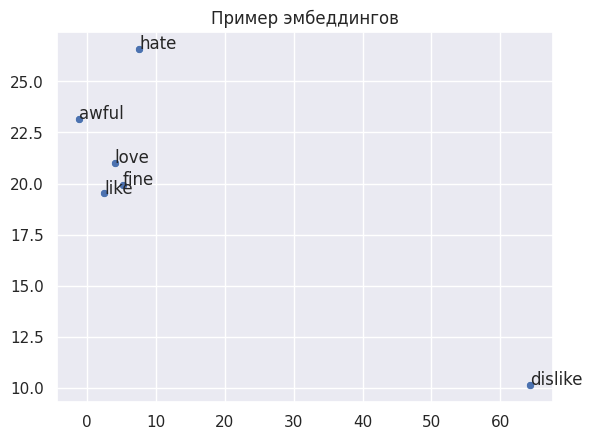

In [71]:
words = []

for word in ['like', 'dislike', 'hate', 'love', 'fine', 'awful']:
    x, y = coocurence_words_emb_tsne[token_to_index[word]]
    words.append((x, y, word))

ax = sns.scatterplot(x=[x[0] for x in words], y=[x[1] for x in words])

for x, y, word in words:
    ax.text(x, y, word)

plt.title('Пример эмбеддингов')

По графику видно, что какие-то слова разделяются, а какие-то нет. Это может быть связано с тем, что даже антонимы могут употрябляться в похожих контекстах.

### PPMI

Подготовим необходимые статистики и матрицу совстречаемости:

In [74]:
from scipy.sparse import csc_matrix, lil_matrix, dok_array

ppmi_matrix = dok_array((len(vocabulary), len(contexts)))

word_counts = np.zeros(len(vocabulary))
context_counts = np.zeros(len(contexts))
coocurence_contex_matrix = dok_array((len(vocabulary), len(contexts)))

for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        coocurence_contex_matrix[token_to_index[current_combination[WINDOW_SIZE // 2]], context_to_index[current_context]] += 1
        context_counts[context_to_index[current_context]] += 1
        word_counts[token_to_index[current_combination[WINDOW_SIZE // 2]]] += 1

  0%|          | 0/50000 [00:00<?, ?it/s]

Расчишаем PPMI матрицу:

In [84]:
non_zero_x, non_zero_y = coocurence_contex_matrix.nonzero()
sum_words = word_counts.sum()
sum_contexts = context_counts.sum()
sum_coocurence = coocurence_contex_matrix.sum()

ppmi_matrix = dok_array((len(vocabulary), len(contexts)))

for x, y in tqdm(zip(non_zero_x, non_zero_y), total=len(non_zero_x)):
    current_ppmi = np.log2((coocurence_contex_matrix[x, y] / sum_coocurence) / ((context_counts[y] / sum_contexts) * (word_counts[x] / sum_words)))
    if current_ppmi > 0:
        ppmi_matrix[x, y] = current_ppmi

  0%|          | 0/5650843 [00:00<?, ?it/s]

Получим эмбеддинги с помоью SVD разложения:

In [85]:
ppmi_words_emb, _, ppmi_contexts_emb = svds(ppmi_matrix, k=10)

Уменьшим размерность с помощью TSNE для визуализации:

In [87]:
ppmi_words_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(ppmi_words_emb)

Text(0.5, 1.0, 'Пример эмбеддингов PPMI')

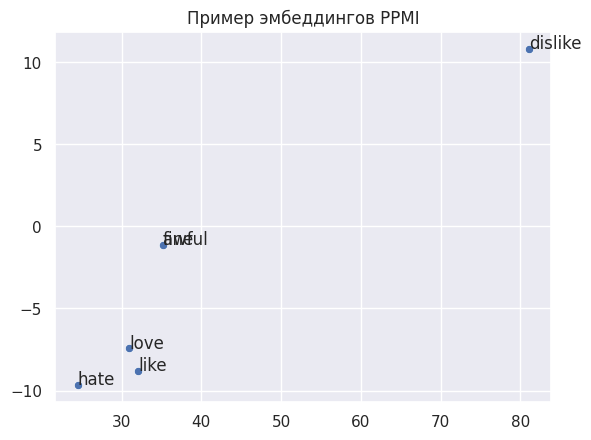

In [92]:
import seaborn as sns
from matplotlib import pyplot as plt

words = []

for word in ['like', 'dislike', 'hate', 'love', 'fine', 'awful']:
    x, y = ppmi_words_emb_tsne[token_to_index[word]]
    words.append((x, y, word))

ax = sns.scatterplot(x=[x[0] for x in words], y=[x[1] for x in words])

for x, y, word in words:
    ax.text(x, y, word)

plt.title('Пример эмбеддингов PPMI')

Так как методы основываются на одном и том то результат похож на предудыщий: какие-то слова разделяются, а какие-то нет.

## W2V

...

# Примечание: Пример, который я в нейронках использовал 

In [15]:
import gensim.downloader
from gensim.models import Word2Vec
import numpy as np

train_sentences = [text.lower() for _, text in train_dataset['preprocessed_review'].items()]

w2v_model = Word2Vec(vector_size=300)
w2v_model.build_vocab((text for _, text in train_dataset_tokenized))
w2v_model.wv.vectors_lockf = np.ones(len(w2v_model.wv))

pretrained_model_path='/kaggle/working/word2vec-google-news-300.gz'
# pretrained_model_path= '/kaggle/working/glove-wiki-gigaword-100.gz'
# pretrained_model_path = gensim.downloader.load('glove-wiki-gigaword-100', return_path=True)
w2v_model.wv.intersect_word2vec_format(pretrained_model_path, lockf=1.0, binary=True)

# Модели

## Классические методы

...

Поделим датасет на обучающую и валидационные выборки (20% на валидацию):

In [12]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

## Нейросетевые подходы

Подготовим исходные данные: токенизируем преобработанный текст

In [14]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

class_to_label = {"positive": 1, "negative": 0}

train_dataset_tokenized = []
for _, row in tqdm(train_dataset.iterrows(), total=len(train_dataset)):
    train_dataset_tokenized.append((class_to_label[row['sentiment']], word_tokenize(row['preprocessed_review'].lower())))
    
test_dataset_tokenized = []
for _, row in tqdm(test_dataset.iterrows(), total=len(test_dataset)):
    test_dataset_tokenized.append((class_to_label[row['sentiment']], word_tokenize(row['preprocessed_review'].lower())))

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [94]:
# !mv /root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz /kaggle/working/glove-wiki-gigaword-100.gz

mv: cannot stat '/root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz': No such file or directory


Подготовим словарь для эмбеддингов в нейросети:

In [16]:
from torchtext.vocab import vocab
from collections import OrderedDict

vocabulary = vocab(OrderedDict((token, 1) for token in w2v_model.wv.key_to_index.keys()), specials=['<UNK>', '<PAD>'], special_first=False)
vocabulary.set_default_index(vocabulary(['<UNK>'])[0])

Подготовим датасеты и функцию предобработки (добавление паддинга и преобразование в нужный формат):

In [17]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import pad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    labels = []
    text_tensors = []
    max_length = max((len(text) for _, text in batch))
    for label, text in batch:
        labels.append(label)
        text_tensors.append(pad(torch.tensor(text), (0, max_length - len(text)), value=vocabulary(['<PAD>'])[0]))        
        
    labels_tensor = torch.tensor(labels)
    text_tensor = torch.vstack(text_tensors)
    return labels_tensor.to(device), text_tensor.to(device)
    

train_dataset_mapped = [(label, vocabulary(text)) for label, text in train_dataset_tokenized]
test_dataset_mapped = [(label, vocabulary(text)) for label, text in test_dataset_tokenized]

train_dataloader = DataLoader(train_dataset_mapped, batch_size=500, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset_mapped, batch_size=100, shuffle=False, collate_fn=collate_batch)

Вспомогательные функции для обучения:

In [18]:
import time
from statistics import mean

def train_step(model, criterion, optimizer, dataloader, epoch_idx, train_accuracy):
    model.train()
    total_acc, total_count = 0, 0
    
    loss_t = [0]
    
    for idx, (label, text) in enumerate(dataloader):
        predicted_label = model(text)
        loss =  criterion(predicted_label, label)
        
#         print("Before")
#         for name, data in model.named_parameters():
#             if data.grad is not None and name == 'fc_1.weight':
#                 print("Name", name)
#                 print("Weights", data.data)
#                 print("Grad", data.grad)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         print("After")
#         for name, data in model.named_parameters():
#             if data.grad is not None and name == 'fc_1.weight':
#                 print("Name", name)
#                 print("Grad", data.grad)
#                 print("Grad", data.grad.norm())

        
        
        current_loss = float(loss.detach().cpu().numpy()) / label.shape[0]        
        loss_t.append(current_loss)
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % 50 == 0:
            print(f"| Epoch {epoch_idx} | batch {idx} | loss {mean(loss_t)}")
        
    accuracy = total_acc / total_count
    print()
    print(f"| Epoch {epoch_idx} | training accuracy {accuracy} | mean loss {mean(loss_t)}")
    train_accuracy[epoch_idx] = accuracy
    

def evaluate_step(model, criterion, dataloader, epoch_idx, eval_accuracy):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    accuracy = total_acc / total_count
    print(f"| Epoch {epoch_idx} | validation accuracy {accuracy}")
    eval_accuracy[epoch_idx] = accuracy


In [19]:
def train(model, criterion, optimizer, epochs, train_dataloader, test_dataloader):
    train_accuracy = {}
    eval_accuracy = {}
    for epoch_idx in range(epochs):
        train_step(model, criterion, optimizer, train_dataloader, epoch_idx, train_accuracy)
        evaluate_step(model, criterion, test_dataloader, epoch_idx, eval_accuracy)
        print()
    
    return train_accuracy, eval_accuracy
        

### CNN модель

Архитектура:

In [20]:
from torch import nn

class CNNModel(nn.Module):
    def __init__(self, embedding_vectors, hidden_size=100, dropout_prob=0.3):
        super(CNNModel, self).__init__()
        
        embedding_size = len(embedding_vectors[0])

        embedding_tensor = torch.vstack([torch.FloatTensor(embedding_vectors), torch.zeros((2, embedding_size))])
        
        self.embeddings = nn.Embedding.from_pretrained(embedding_tensor)
#         self.embeddings = nn.Embedding(len(embedding_vectors) + 2, embedding_size)
        
        self.convolution_1 = nn.Conv1d(embedding_size, hidden_size, 5)
        self.convolution_2 = nn.Conv1d(embedding_size, hidden_size, 15)
        self.convolution_3 = nn.Conv1d(embedding_size, hidden_size, 45)
        
        self.avg_max_pooling = nn.AdaptiveAvgPool1d(1)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.batch_norm = nn.BatchNorm1d(hidden_size * 3,)
        
        self.fc = nn.Linear(hidden_size * 3, 2)
        
        
    def forward(self, batch):        
        with torch.no_grad():
            embeddings = self.embeddings(batch).transpose(1, 2)     
    
        conv_1 = self.convolution_1(embeddings)
        pooling_1 = self.dropout(self.avg_max_pooling(conv_1).squeeze(-1))
        conv_2 = self.convolution_1(embeddings)
        pooling_2 = self.dropout(self.avg_max_pooling(conv_2).squeeze(-1))
        conv_3 = self.convolution_1(embeddings)
        pooling_3 = self.dropout(self.avg_max_pooling(conv_3).squeeze(-1))
        
        
        hidden_state = self.batch_norm(torch.cat([pooling_1, pooling_2, pooling_3], dim=1))
        
        return nn.functional.softmax(nn.functional.relu(self.fc(hidden_state)), dim=-1)         
        
        

In [21]:
cnn_model = CNNModel(w2v_model.wv.vectors, hidden_size=100, dropout_prob=0.5).to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
cnn_train_results = train(cnn_model, criterion, optimizer, 10, train_dataloader, test_dataloader)

| Epoch 0 | batch 0 | loss 0.0007027208805084229
| Epoch 0 | batch 50 | loss 0.0010462546463196095

| Epoch 0 | training accuracy 0.803925 | mean loss 0.0010064155334307823
| Epoch 0 | validation accuracy 0.8402

| Epoch 1 | batch 0 | loss 0.00045366445183753966
| Epoch 1 | batch 50 | loss 0.0009083018520703683

| Epoch 1 | training accuracy 0.84335 | mean loss 0.000916404585779449
| Epoch 1 | validation accuracy 0.8245

| Epoch 2 | batch 0 | loss 0.0004655260145664215
| Epoch 2 | batch 50 | loss 0.0009066071028892811

| Epoch 2 | training accuracy 0.84505 | mean loss 0.000910892591064359
| Epoch 2 | validation accuracy 0.8461

| Epoch 3 | batch 0 | loss 0.00043399545550346373
| Epoch 3 | batch 50 | loss 0.0008911835184464088

| Epoch 3 | training accuracy 0.850825 | mean loss 0.0009022616052333219
| Epoch 3 | validation accuracy 0.8471

| Epoch 4 | batch 0 | loss 0.00044526302814483645
| Epoch 4 | batch 50 | loss 0.0008925476784889515

| Epoch 4 | training accuracy 0.852375 | mean los

Text(0.5, 1.0, 'CNN модель')

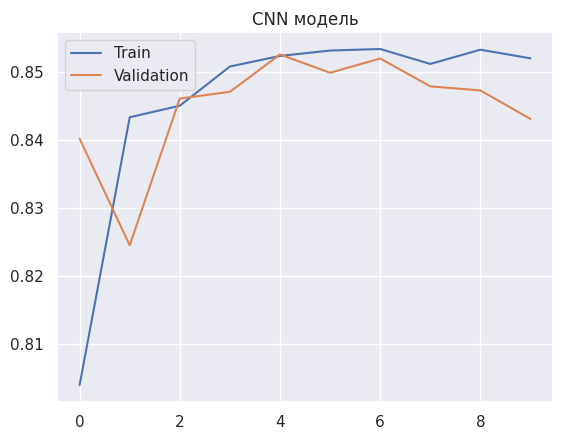

In [24]:
from matplotlib import pyplot as plt
sns.set_theme()

plt.plot(list(cnn_train_results[0].keys()), list(cnn_train_results[0].values()), label='Train')
plt.plot(list(cnn_train_results[1].keys()), list(cnn_train_results[1].values()), label='Validation')
plt.legend()
plt.title('CNN модель')

Лучший результат на валидации:

In [31]:
max(cnn_train_results[1].values())

0.8526

### MLP модель

Архитектура (в качестве эмбеддинга отзыва возмем среднее всех эмбеддингов слов):

In [26]:
from torch import nn

class MLPModel(nn.Module):
    def __init__(self, embedding_vectors, hidden_size=100, dropout_prob=0.5):
        super(MLPModel, self).__init__()
        
        embedding_size = len(embedding_vectors[0])

        embedding_tensor = torch.vstack([torch.FloatTensor(embedding_vectors), torch.zeros((2, embedding_size))])
        
        self.embeddings = nn.Embedding.from_pretrained(embedding_tensor)
#         self.embeddings = nn.Embedding(len(embedding_vectors) + 2, embedding_size)
        
        self.fc_1 = nn.Linear(embedding_size, hidden_size)
        
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        self.fc_2 = nn.Linear(hidden_size, 2)
        
        self.dropout_1 = nn.Dropout(dropout_prob)
#         self.dropout_2 = nn.Dropout(dropout_prob)


    def forward(self, batch):       
        with torch.no_grad():
            embeddings_raw = self.embeddings(batch).transpose(1, 2)
            embeddings = embeddings_raw.mean(dim=-1)
    
        hidden_state_1 = self.dropout_1(nn.functional.relu(self.batch_norm(self.fc_1(embeddings))))
        
#         print(hidden_state_1.requires_grad)
        hidden_state_2 = self.fc_2(hidden_state_1)

        return nn.functional.softmax(hidden_state_2, dim=-1)         
        
        

In [27]:
mlp_model = MLPModel(w2v_model.wv.vectors, hidden_size=50).to(device)

optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()
mlp_train_results = train(mlp_model, criterion, optimizer, 10, train_dataloader, test_dataloader)


| Epoch 0 | batch 0 | loss 0.0007090119123458862
| Epoch 0 | batch 50 | loss 0.001205284072802617

| Epoch 0 | training accuracy 0.740775 | mean loss 0.0011558290190166896
| Epoch 0 | validation accuracy 0.759

| Epoch 1 | batch 0 | loss 0.0005169191360473633
| Epoch 1 | batch 50 | loss 0.0009908955819331682

| Epoch 1 | training accuracy 0.828025 | mean loss 0.0009859861893418394
| Epoch 1 | validation accuracy 0.8286

| Epoch 2 | batch 0 | loss 0.00048348382115364074
| Epoch 2 | batch 50 | loss 0.0009435675614155256

| Epoch 2 | training accuracy 0.840625 | mean loss 0.0009434393121872419
| Epoch 2 | validation accuracy 0.8354

| Epoch 3 | batch 0 | loss 0.0004726683497428894
| Epoch 3 | batch 50 | loss 0.000916588870378641

| Epoch 3 | training accuracy 0.847075 | mean loss 0.0009235382705558965
| Epoch 3 | validation accuracy 0.8457

| Epoch 4 | batch 0 | loss 0.0004537814557552338
| Epoch 4 | batch 50 | loss 0.0009091042108260669

| Epoch 4 | training accuracy 0.849675 | mean loss

Text(0.5, 1.0, 'MLP модель')

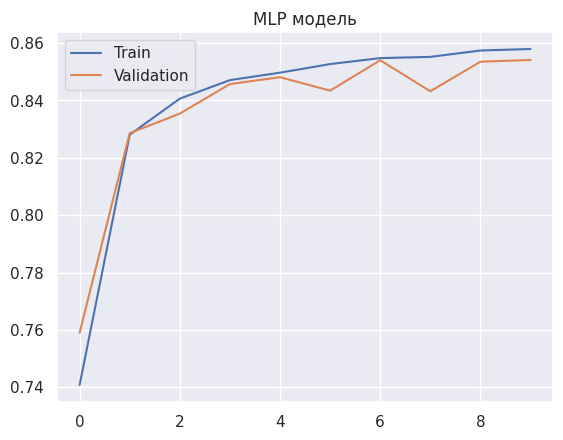

In [28]:
plt.plot(list(mlp_train_results[0].keys()), list(mlp_train_results[0].values()), label='Train')
plt.plot(list(mlp_train_results[1].keys()), list(mlp_train_results[1].values()), label='Validation')
plt.legend()
plt.title('MLP модель')

Лучший результат на валидации:

In [32]:
max(mlp_train_results[1].values())

0.8541

**Выводы**: неожиданно лучше себя показала самая базовая модель MLP, которая не учитывает контекст.

Возможные объяснения:
1. Подобраны не совсем оптимальные гиперпараметры
2. Отзывы насколько полярны, что даже средний эмбеддинг хорошо отделим 
3. Архитектура CNN в нашей реализации плохо себя показывает

Возможные варианты улучшения качества: 
1. Другие более сложные архитектуры 
2. Подбор гиперпараметров
3. Дополнительная преобработка датасета